In [0]:
# Importing Libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = '/content/drive/My Drive/HumanActivityRecognition/HAR/UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/HumanActivityRecognition/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/HumanActivityRecognition/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [12]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [14]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [17]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [21]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [0]:
# Initializing parameters
epochs = 50
batch_size = 100
n_hidden = 256

In [18]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.30))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               272384    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 273,926
Trainable params: 273,926
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [20]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7352 samples, validate on 2947 samples
Epoch 1/50




7352/7352 [==============================] - 22s 3ms/step - loss: 1.4166 - acc: 0.3781 - val_loss: 1.2801 - val_acc: 0.4907
Epoch 2/50
7352/7352 [==============================] - 13s 2ms/step - loss: 1.2602 - acc: 0.4584 - val_loss: 1.2215 - val_acc: 0.4659
Epoch 3/50
7352/7352 [==============================] - 13s 2ms/step - loss: 1.0909 - acc: 0.5083 - val_loss: 1.2319 - val_acc: 0.4340
Epoch 4/50
7352/7352 [==============================] - 13s 2ms/step - loss: 1.2146 - acc: 0.4415 - val_loss: 1.4156 - val_acc: 0.3498
Epoch 5/50
7352/7352 [==============================] - 13s 2ms/step - loss: 1.3867 - acc: 0.3591 - val_loss: 1.3975 - val_acc: 0.3515
Epoch 6/50
7352/7352 [==============================] - 13s 2ms/step - loss: 1.1597 - acc: 0.4736 - val_loss: 0.9785 - val_acc: 0.6067
Epoch 7/50
7352/7352 [====================

In [21]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  5      387  ...                   0                 1
STANDING                 0       97  ...                   0                 0
WALKING                  0        0  ...                  14                 0
WALKING_DOWNSTAIRS       0        0  ...                 418                 1
WALKING_UPSTAIRS         0        1  ...                   1               464

[6 rows x 6 columns]


In [22]:
score_model1 = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 5s 2ms/step


In [23]:
score_model1

[0.23366940406341205, 0.9239904988123515]

In [0]:
#https://github.com/sunneysood/Tensorflow/blob/master/Multi_Layer_LSTM.ipynb
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

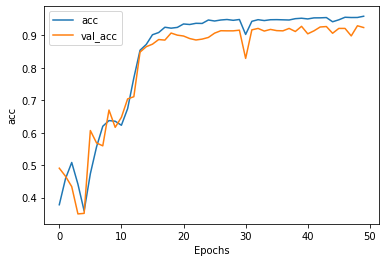

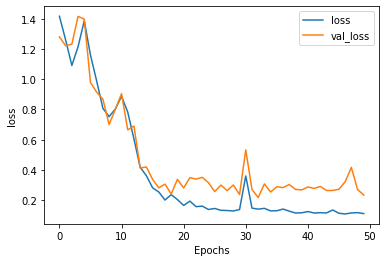

In [25]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

# Model 2

In [0]:
# Initializing parameters
epochs = 50
batch_size = 100
n_hidden = 64

In [27]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.60))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [29]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 13s 2ms/step - loss: 1.4521 - acc: 0.3745 - val_loss: 1.3466 - val_acc: 0.4157
Epoch 2/50
7352/7352 [==============================] - 13s 2ms/step - loss: 1.2343 - acc: 0.4758 - val_loss: 1.1975 - val_acc: 0.4662
Epoch 3/50
7352/7352 [==============================] - 13s 2ms/step - loss: 1.1193 - acc: 0.5069 - val_loss: 1.1867 - val_acc: 0.5005
Epoch 4/50
7352/7352 [==============================] - 13s 2ms/step - loss: 1.0557 - acc: 0.5099 - val_loss: 1.1546 - val_acc: 0.4706
Epoch 5/50
7352/7352 [==============================] - 13s 2ms/step - loss: 1.0820 - acc: 0.4927 - val_loss: 1.1243 - val_acc: 0.4737
Epoch 6/50
7352/7352 [==============================] - 13s 2ms/step - loss: 1.1131 - acc: 0.5007 - val_loss: 1.1292 - val_acc: 0.5467
Epoch 7/50
7352/7352 [==============================] - 13s 2ms/step - loss: 1.0350 - acc: 0.5324 - val_loss: 1.0944 - val_acc: 0.5154
Epoch 8

In [30]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                27
SITTING                  2      376  ...                   0                 0
STANDING                 0       71  ...                   0                 0
WALKING                  0        0  ...                   1                31
WALKING_DOWNSTAIRS       0        0  ...                 346                73
WALKING_UPSTAIRS         0        1  ...                  15               429

[6 rows x 6 columns]


In [31]:
score_model2 = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 5s 2ms/step


In [32]:
score_model2

[0.3825929564366027, 0.8754665761791652]

In [0]:
#https://github.com/sunneysood/Tensorflow/blob/master/Multi_Layer_LSTM.ipynb
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

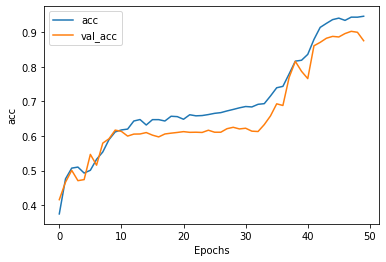

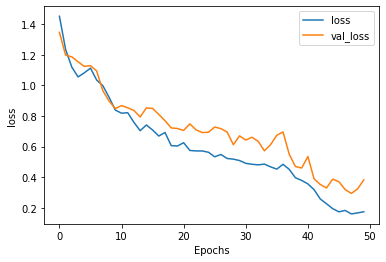

In [34]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

- With a simple 2 layer architecture and high dropout we got 62.85% accuracy and a loss of 0.66

# Model 3

In [0]:
#https://towardsdatascience.com/neural-network-with-tensorflow-how-to-stop-training-using-callback-5c8d575c18a9

# when accuracy reaches ACCURACY_THRESHOLD
from keras.callbacks import Callback

ACCURACY_THRESHOLD = 0.94

class myCallback(Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_acc') > ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()


In [0]:
# Initializing parameters
epochs = 100
batch_size = 200
n_hidden = 200

In [94]:
# Initiliazing the sequential model
from keras.layers import BatchNormalization
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim),return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.45))
model.add(BatchNormalization())
model.add(LSTM(n_hidden - 32))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 128, 200)          168000    
_________________________________________________________________
dropout_29 (Dropout)         (None, 128, 200)          0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 128, 200)          800       
_________________________________________________________________
lstm_39 (LSTM)               (None, 168)               247968    
_________________________________________________________________
dropout_30 (Dropout)         (None, 168)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 1014      
Total params: 417,782
Trainable params: 417,382
Non-trainable params: 400
_____________________________________________

In [0]:
# Compiling the model
#https://stackoverflow.com/questions/56977277/default-adam-optimizer-doesnt-work-in-tf-keras-but-string-adam-does
#https://stackoverflow.com/questions/50056356/could-not-interpret-optimizer-identifier-error-in-keras

#from tensorflow.python.keras.optimizer_v2.adam import Adam


#from keras.optimizers import adam
#adam = adam(lr=0.001,decay = 1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [96]:
# Training the model
history = model.fit(X_train, Y_train,
          callbacks=[callbacks],
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 33s 5ms/step - loss: 1.0837 - acc: 0.5945 - val_loss: 1.4406 - val_acc: 0.4055
Epoch 2/100
7352/7352 [==============================] - 23s 3ms/step - loss: 0.5407 - acc: 0.8160 - val_loss: 1.5593 - val_acc: 0.5365
Epoch 3/100
7352/7352 [==============================] - 23s 3ms/step - loss: 0.2936 - acc: 0.9057 - val_loss: 0.4098 - val_acc: 0.8521
Epoch 4/100
7352/7352 [==============================] - 23s 3ms/step - loss: 0.1937 - acc: 0.9302 - val_loss: 0.4058 - val_acc: 0.8619
Epoch 5/100
7352/7352 [==============================] - 23s 3ms/step - loss: 0.1546 - acc: 0.9423 - val_loss: 0.2776 - val_acc: 0.9101
Epoch 6/100
7352/7352 [==============================] - 23s 3ms/step - loss: 0.1455 - acc: 0.9430 - val_loss: 0.3506 - val_acc: 0.8772
Epoch 7/100
7352/7352 [==============================] - 23s 3ms/step - loss: 0.1833 - acc: 0.9339 - val_loss: 0.2906 - val_acc: 0.8968


In [97]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  5      418  ...                   0                 4
STANDING                 0       77  ...                   0                 0
WALKING                  0        0  ...                   4                 1
WALKING_DOWNSTAIRS       0        0  ...                 414                 1
WALKING_UPSTAIRS         0        0  ...                   0               456

[6 rows x 6 columns]


In [98]:
score_model3 = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 19s 6ms/step


In [99]:
score_model3

[0.22652217569071587, 0.9402782490668476]

In [0]:
#https://github.com/sunneysood/Tensorflow/blob/master/Multi_Layer_LSTM.ipynb
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

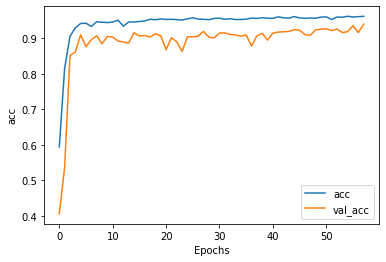

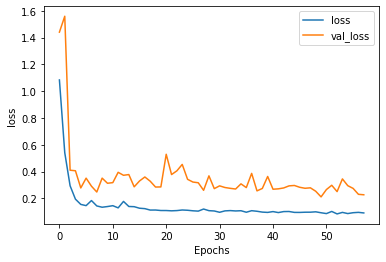

In [101]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

- With a simple 2 layer architecture we got 92.19% accuracy and a loss of 0.38


# Conclusion

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Test Loss", "Test Accuracy"]

x.add_row(["Increase LSTM Units",score_model1[0],score_model1[1]])
x.add_row(["Increase Dropouts",score_model2[0],score_model2[1]])
x.add_row(["Increase LSTM Layers with increased Dropouts",score_model3[0],score_model3[1]])
print(x)

